In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna
from scipy.interpolate import RegularGridInterpolator

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Plot noise 
def plot_bar_chart(ac_name, epnl, limits, epnl_approach): 
    hatch = ['', '//']

    fig, ax = plt.subplots(1,1, figsize=(15,4))
    plt.style.use('../utils/plot.mplstyle')

    for i, case in enumerate(case_lst):

        bar_l = ax.bar(np.linspace(-0.3, +0.3, 4)+0+0.09*i-0.04, epnl[case]['lateral']-limits['lateral'], width=0.08, color=colors, hatch=hatch[i])
        bar_f = ax.bar(np.linspace(-0.3, +0.3, 4)+1+0.09*i-0.04, epnl[case]['flyover']-limits['flyover'], width=0.08, color=colors, hatch=hatch[i])
        bar_t = ax.bar(np.linspace(-0.3, +0.3, 4)+2+0.09*i-0.04, (epnl[case]['takeoff']+epnl_approach)-limits['cumulative'], width=0.08, color=colors, hatch=hatch[i])
        ax.set_xticks(np.arange(3))
        ax.set_xticklabels(['Lateral', 'Flyover', 'Cumulative'])
        ax.set_ylabel('$\Delta EPNL_{chapter\ 14}$\n[EPNdB]')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.plot([-0.5, 2.5], [0,0], 'k', linewidth=1)
        ax.set_xlim([-0.5, 2.5])
        
        if ac_name == 'stca':
            cb_alt = 260
            ax.set_ylim([-12,15.])
            ax.set_yticks(np.arange(-12, 15.1, 3))
        elif ac_name == 'a10':
            cb_alt = 210
            ax.set_ylim([-6, 18])
            ax.set_yticks(np.arange(-6, 18.1, 3))

        if i == 0:
            ax.fill_between([18,19], [8,8], [9,9], color='tab:blue', label='STCB ($z_{cb} \geq$'+str(cb_alt)+'m)', hatch=hatch[i])
            ax.fill_between([18,19], [8,8], [9,9], color='tab:orange', label='STCB ($z_{cb} <$'+str(cb_alt)+'m)', hatch=hatch[i])
            ax.fill_between([18,19], [8,8], [9,9], color='tab:green', label='PTCB', hatch=hatch[i])
#             ax.fill_between([18,19], [8,8], [9,9], color='tab:red', label='PHLD', hatch=hatch[i])

    ax.annotate("", xy=(1.55, 7.2), xycoords='data', xytext=(1.55, -0.2), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=16)
    ax.plot([1.3, 2.5], [7, 7], 'k-', linewidth=1)
    ax.annotate(s="Chapter 4", xy=(1.3, 7.7), fontsize=16)

    if ac_name == 'a10':
        ax.plot([1.3, 2.5], [17, 17], 'k-', linewidth=1)
        ax.annotate(s="Chapter 3", xy=(1.3, 17.7), fontsize=16)
        ax.annotate("", xy=(1.47, 6.5), xycoords='data', xytext=(1.47, -0.2), textcoords='data', arrowprops=dict(arrowstyle="-", connectionstyle="arc3"), fontsize=16)
        ax.annotate("", xy=(1.47, 17.2), xycoords='data', xytext=(1.47, 10.), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=16)
        
    ax2 = ax.twinx()
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xticks([-0.1, 0.9, 1.9])
    ax2.set_xticklabels(['Lateral', 'Flyover', 'Cumulative'])
    ax2.set_yticks([])
    ax2.fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = $V_2$ + 20 kts', hatch='')
    ax2.fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = 250 kts', hatch='//')

    ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.39), ncol=1, borderaxespad=0, frameon=False)
    ax2.legend(loc='lower left', bbox_to_anchor=(1.0, -0.05), ncol=1, borderaxespad=0, frameon=False)

In [3]:
# Inputs 
ac_lst = ['stca', 'a10']
case_lst = ['V2', 'Vmax']
trajectory_lst = ['stcb_base', 'stcb_adv', 'ptcb', 'phld']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.75, 1.0, 11)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.775, 1.0, 10)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.675, 1.0, 14)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444

lateral_attenuation = True

In [31]:
# Load 
stcb_sweeps = dict()
ptcb_sweeps = dict()
idx_stcb_control = dict()
stcb_control = dict()
traj = dict()
epnl = dict()

for ac_name in ac_lst:
    
    stcb_sweeps[ac_name] = dict()
    ptcb_sweeps[ac_name] = dict()
    idx_stcb_control[ac_name] = dict()
    stcb_control[ac_name] = dict()
    traj[ac_name] = dict()
    epnl[ac_name] = dict()
    
    for case in case_lst:

        # Start of sideline noise 
        if ac_name == 'stca' and case == 'V2':
            start = 28
        elif ac_name == 'stca' and case == 'Vmax':
            start = 46
        elif ac_name == 'a10' and case == 'V2':
            start = 64
        elif ac_name == 'a10' and case == 'Vmax':
            start = 76
                        
        # Load STCB sweeps
        stcb_sweeps[ac_name][case] = dict()
        if not lateral_attenuation:
            stcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_sideline_nolatatt.npy') 
            stcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_flyover_nolatatt.npy') 
        else:
            stcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_sideline.npy') 
            stcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/STCB/' + case + '/sweeps/epnl_flyover.npy') 
        stcb_sweeps[ac_name][case]['lateral']  = np.max(stcb_sweeps[ac_name][case]['sideline'][:,:,start:], axis=2)
        stcb_sweeps[ac_name][case]['takeoff']  = stcb_sweeps[ac_name][case]['lateral'] + stcb_sweeps[ac_name][case]['flyover'] 

        # Load PTCB sweeps
        ptcb_sweeps[ac_name][case] = dict()
        if ac_name == 'stca' and case == 'V2':
            ptcb_sweeps[ac_name][case]['sideline'] = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '_lat_limit/epnl_sideline.npy') 
            ptcb_sweeps[ac_name][case]['flyover']  = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '_lat_limit/epnl_flyover.npy') 
            ptcb_sweeps[ac_name][case]['lateral']  = np.max(ptcb_sweeps[ac_name][case]['sideline'][20:])
            ptcb_sweeps[ac_name][case]['takeoff']  = ptcb_sweeps[ac_name][case]['lateral'] + ptcb_sweeps[ac_name][case]['flyover']

        # Get index of key STCB controls
        idx_stcb_control[ac_name][case] = dict()
        epnl_sub = np.copy(stcb_sweeps[ac_name][case]['takeoff'])
        epnl_sub[:10, :] = 1000*np.ones((10, epnl_sub.shape[1]))
        idx_stcb_control[ac_name][case]['std'] = np.unravel_index(np.argmin(epnl_sub, axis=None), epnl_sub.shape)
        epnl_sub = stcb_sweeps[ac_name][case]['takeoff'][:10, :]
        idx_stcb_control[ac_name][case]['adv'] = np.unravel_index(np.argmin(epnl_sub, axis=None), epnl_sub.shape)

        # Get key STCB controls
        stcb_control[ac_name][case] = dict()
        stcb_control[ac_name][case]['z_cb'] = dict()
        stcb_control[ac_name][case]['TS_cb'] = dict()
        stcb_control[ac_name][case]['z_cb']['std'] = z_cb_lst[idx_stcb_control[ac_name][case]['std'][0]]
        stcb_control[ac_name][case]['z_cb']['adv'] = z_cb_lst[idx_stcb_control[ac_name][case]['adv'][0]]
        stcb_control[ac_name][case]['TS_cb']['std'] = TS_cb_lst[ac_name][case][idx_stcb_control[ac_name][case]['std'][1]]
        stcb_control[ac_name][case]['TS_cb']['adv'] = TS_cb_lst[ac_name][case][idx_stcb_control[ac_name][case]['adv'][1]]
        
        # Get epnl
        epnl[ac_name][case] = dict()
        epnl[ac_name][case]['lateral'] = np.zeros(4)
        epnl[ac_name][case]['flyover'] = np.zeros(4)
        epnl[ac_name][case]['takeoff'] = np.zeros(4)
        epnl[ac_name][case]['lateral'][0] = stcb_sweeps[ac_name][case]['lateral'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['flyover'][0] = stcb_sweeps[ac_name][case]['flyover'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['takeoff'][0] = stcb_sweeps[ac_name][case]['takeoff'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['lateral'][1] = stcb_sweeps[ac_name][case]['lateral'][idx_stcb_control[ac_name][case]['adv']]
        epnl[ac_name][case]['flyover'][1] = stcb_sweeps[ac_name][case]['flyover'][idx_stcb_control[ac_name][case]['adv']]
        epnl[ac_name][case]['takeoff'][1] = stcb_sweeps[ac_name][case]['takeoff'][idx_stcb_control[ac_name][case]['adv']]
        if ac_name == 'stca' and case == 'V2':
            epnl[ac_name][case]['lateral'][2] = ptcb_sweeps[ac_name][case]['lateral']
            epnl[ac_name][case]['flyover'][2] = ptcb_sweeps[ac_name][case]['flyover']
            epnl[ac_name][case]['takeoff'][2] = ptcb_sweeps[ac_name][case]['takeoff']
        else:
            epnl[ac_name][case]['lateral'][2] = np.nan
            epnl[ac_name][case]['flyover'][2] = np.nan
            epnl[ac_name][case]['takeoff'][2] = np.nan
        epnl[ac_name][case]['lateral'][3] = np.nan
        epnl[ac_name][case]['flyover'][3] = np.nan
        epnl[ac_name][case]['takeoff'][3] = np.nan
        
        epnl[ac_name][case]['sideline'] = dict()
        epnl[ac_name][case]['sideline']['std'] = stcb_sweeps[ac_name][case]['sideline'][idx_stcb_control[ac_name][case]['std']]
        epnl[ac_name][case]['sideline']['adv'] = stcb_sweeps[ac_name][case]['sideline'][idx_stcb_control[ac_name][case]['adv']]
        if ac_name == 'stca' and case == 'V2':
            epnl[ac_name][case]['sideline']['ptcb'] = np.load('../cases/'+ac_name+'/output/PTCB/' + case + '_lat_limit/epnl_sideline.npy') 
        
        # Get trajectories
        traj[ac_name][case] = dict()
        traj[ac_name][case]['std'] = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['std'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['std'], 3))+'.csv')
        traj[ac_name][case]['adv'] = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_'+ac_name+'_'+str(stcb_control[ac_name][case]['z_cb']['adv'])+'_'+str(np.round(stcb_control[ac_name][case]['TS_cb']['adv'], 3))+'.csv')
        if ac_name == 'stca' and case == 'V2':
            traj[ac_name][case]['ptcb'] = pd.read_csv('../cases/'+ac_name+'/trajectory/PTCB/'+case+'_lat_limit/trajectory_'+ac_name+'_ptcb_'+case+'.csv')

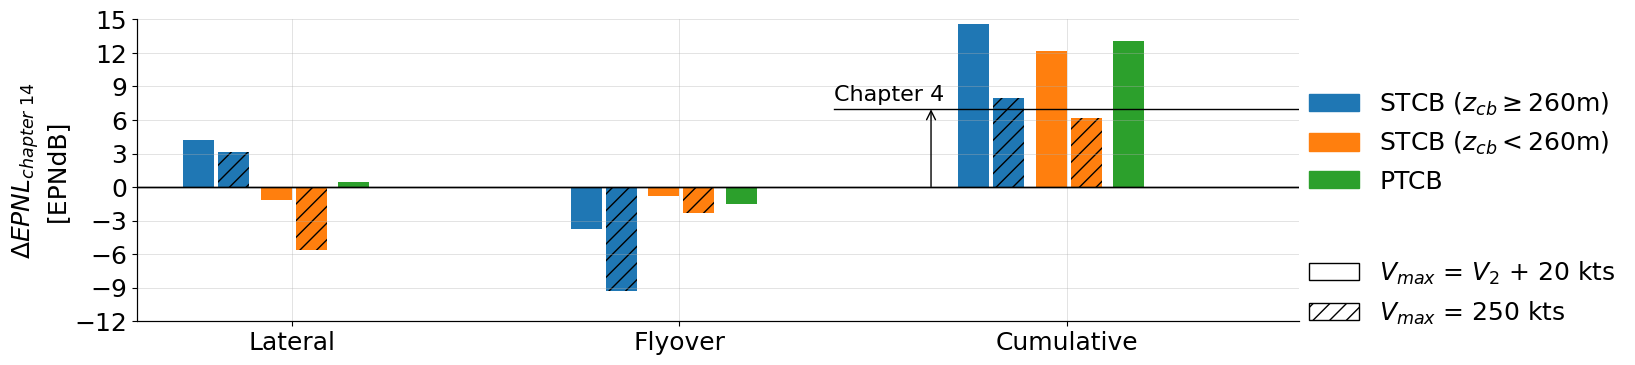

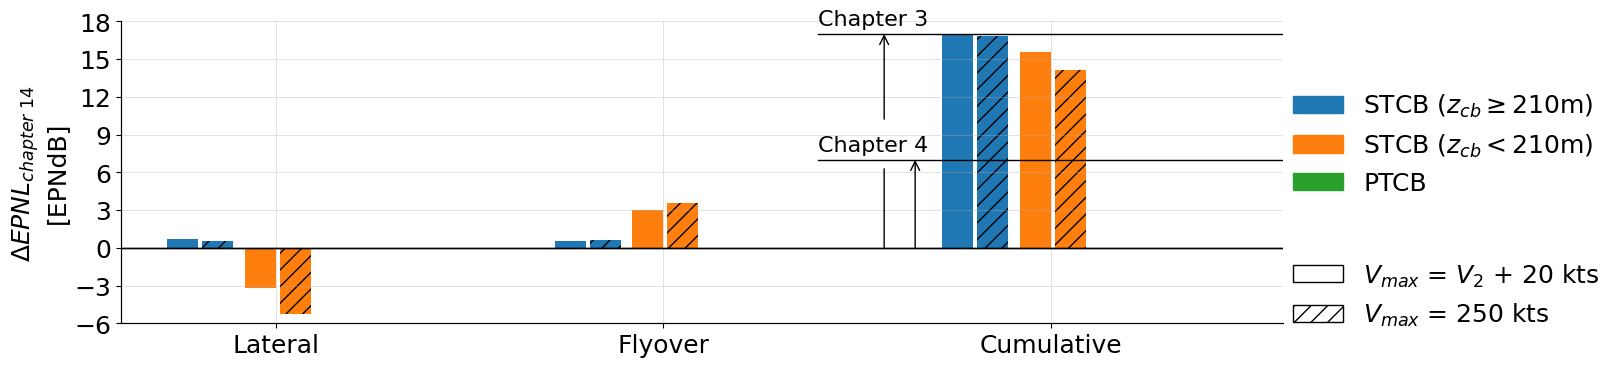

In [32]:
limits_stca = pyna.load_annex16_noise_limits(mtow=np.array([55.]), chapter='14', n_eng=3)
plot_bar_chart('stca', epnl['stca'], limits_stca, epnl_approach=98.6)

limits_a10 = pyna.load_annex16_noise_limits(mtow=np.array([166.5]), chapter='14', n_eng=3)
plot_bar_chart('a10', epnl['a10'], limits_a10, epnl_approach=104.)

In [53]:
# Get k_rot of advanced trajectories

### STCA
pyna_settings = pyna.load_settings(case_name='stca')
pyna_settings.case_name = 'stca'
pyna_settings.ac_name = 'stca'

pyna_settings.output_directory_name = 'STCB/V2'
py = pyna(pyna_settings)
z_cb = stcb_control['stca']['V2']['z_cb']['adv']
TS = stcb_control['stca']['V2']['TS_cb']['adv']
results = py.load_results(file_name=pyna_settings.ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.sql')
print(results.get_val('phases.groundroll.parameters:k_rot'))

pyna_settings.output_directory_name = 'STCB/Vmax'
py = pyna(pyna_settings)
z_cb = stcb_control['stca']['Vmax']['z_cb']['adv']
TS = stcb_control['stca']['Vmax']['TS_cb']['adv']
results = py.load_results(file_name=pyna_settings.ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.sql')
print(results.get_val('phases.groundroll.parameters:k_rot'))

### A10
pyna_settings = pyna.load_settings(case_name='a10')
pyna_settings.case_name = 'a10'
pyna_settings.ac_name = 'a10'

pyna_settings.output_directory_name = 'STCB/V2'
py = pyna(pyna_settings)
z_cb = stcb_control['a10']['V2']['z_cb']['adv']
TS = stcb_control['a10']['V2']['TS_cb']['adv']
results = py.load_results(file_name=pyna_settings.ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.sql')
print(results.get_val('phases.groundroll.parameters:k_rot'))

pyna_settings.output_directory_name = 'STCB/Vmax'
py = pyna(pyna_settings)
z_cb = stcb_control['a10']['Vmax']['z_cb']['adv']
TS = stcb_control['a10']['Vmax']['TS_cb']['adv']
results = py.load_results(file_name=pyna_settings.ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.sql')
print(results.get_val('phases.groundroll.parameters:k_rot'))


[1.24204863]
[1.59999739]
[1.41274722]
[1.52464716]


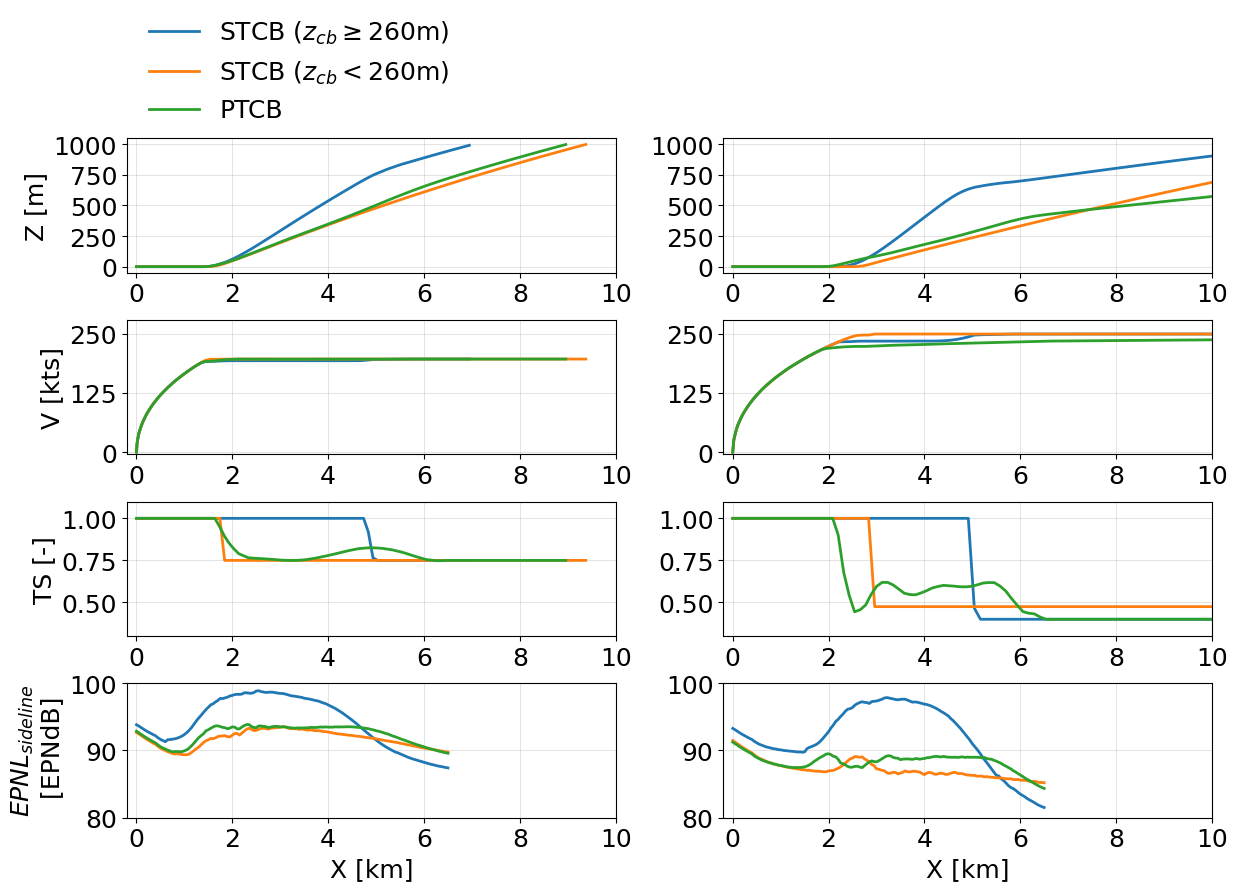

In [72]:
fig, ax = plt.subplots(4,2, figsize=(14, 9))
color_lst = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyle_lst = ['-', '-']

V2_lst = dict()
V2_lst['stca'] = 177
V2_lst['a10'] = 213.4

x_iter = np.linspace(0, 6500, 131)

ac_name = 'stca'
for j,case in enumerate(['V2', 'Vmax']):
    for i,traj_name in enumerate(traj[ac_name][case].keys()):

        idx = np.where(traj[ac_name][case][traj_name]['Z [m]'] <= 1000)[0]
        
        # Labels for trajectories
        if ac_name == 'stca':
            label = ['STCB ($z_{cb}\geq 260$m)', 'STCB ($z_{cb}<260$m)', 'PTCB', 'PHLD']
        elif ac_name == 'a10':
            label = ['STCB ($z_{cb}\geq 210$m)', 'STCB ($z_{cb}<210$m)', 'PTCB', 'PHLD']
             
        # Plot trajectories
        if case == 'V2':
            ax[0, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['Z [m]'][idx], color=color_lst[i], linestyle=linestyle_lst[j], label=label[i])
            ax[1, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['V [m/s]'][idx]/0.51444, color=color_lst[i], linestyle=linestyle_lst[j])    
            ax[2, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['TS [-]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])    
            ax[3, j].plot(np.linspace(0, 6500, 131)/1000, epnl[ac_name][case]['sideline'][traj_name], color=color_lst[i], linestyle=linestyle_lst[j])    
            
        elif case == 'Vmax':
            ax[0, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['Z [m]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])
            ax[1, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['V [m/s]'][idx]/0.51444, color=color_lst[i], linestyle=linestyle_lst[j])
            ax[2, j].plot(traj[ac_name][case][traj_name]['X [m]'][idx]/1000, traj[ac_name][case][traj_name]['TS [-]'][idx], color=color_lst[i], linestyle=linestyle_lst[j])
            ax[3, j].plot(np.linspace(0, 6500, 131)/1000, epnl[ac_name][case]['sideline'][traj_name], color=color_lst[i], linestyle=linestyle_lst[j])    
       
    # 
    if ac_name == 'stca':
        ax[0,j].set_ylim([-50, 1050])
        ax[3,j].set_ylim([80, 100])
#         ax[3,0].annotate(xy=(0, 81), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
#         ax[3,1].annotate(xy=(0, 81), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
        
        if  case == 'V2':
            start = 28
        elif  case == 'Vmax':
            start = 46
#         ax[3,j].fill_between([-1.000, x_iter[start]/1000.], [80, 80], [105, 105], color='grey', alpha=0.2, hatch='//')        
                
    elif ac_name == 'a10':    
        ax[0,j].set_ylim([-50, 750])
        ax[3,j].set_ylim([87, 102])
        ax[3,j].annotate(xy=(0, 88), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
        ax[3,j].annotate(xy=(0, 88), s='EPNL\nILL-DEFINED', fontsize=16, color='k')
        
        if case == 'V2':
            start = 64
        elif case == 'Vmax':
            start = 76
        ax[3,j].fill_between([-1.000, x_iter[start]/1000.], [80, 80], [105, 105], color='grey', alpha=0.2, hatch='//')
        
    ax[0,j].set_xlim([-0.200, 10.])
    ax[0,j].set_yticks([0.0, 250., 500., 750., 1000.])    
    ax[1,j].set_xlim([-0.200, 10.])
    ax[1,j].set_ylim([-5, 280])
    ax[1,j].set_yticks([0., 125., 250.])
    ax[2,j].set_xlim([-0.200, 10.])
    ax[2,j].set_ylim([0.3, 1.1])
    ax[2,j].set_yticks([0.5, 0.75, 1.0])
    ax[3,j].set_xlim([-0.200, 10.])

    
ax[0,0].set_ylabel('Z [m]')
ax[1,0].set_ylabel('V [kts]')
ax[2,0].set_ylabel('TS [-]')
ax[3,0].set_ylabel('$EPNL_{sideline}$\n [EPNdB]')
ax[3,0].set_xlabel('X [km]')
ax[0,0].legend(loc='lower left', bbox_to_anchor=(0,0.95), frameon=False)
ax[3,1].set_xlabel('X [km]')


plt.subplots_adjust(hspace=0.35, wspace=0.22)

KeyError: 'V2'

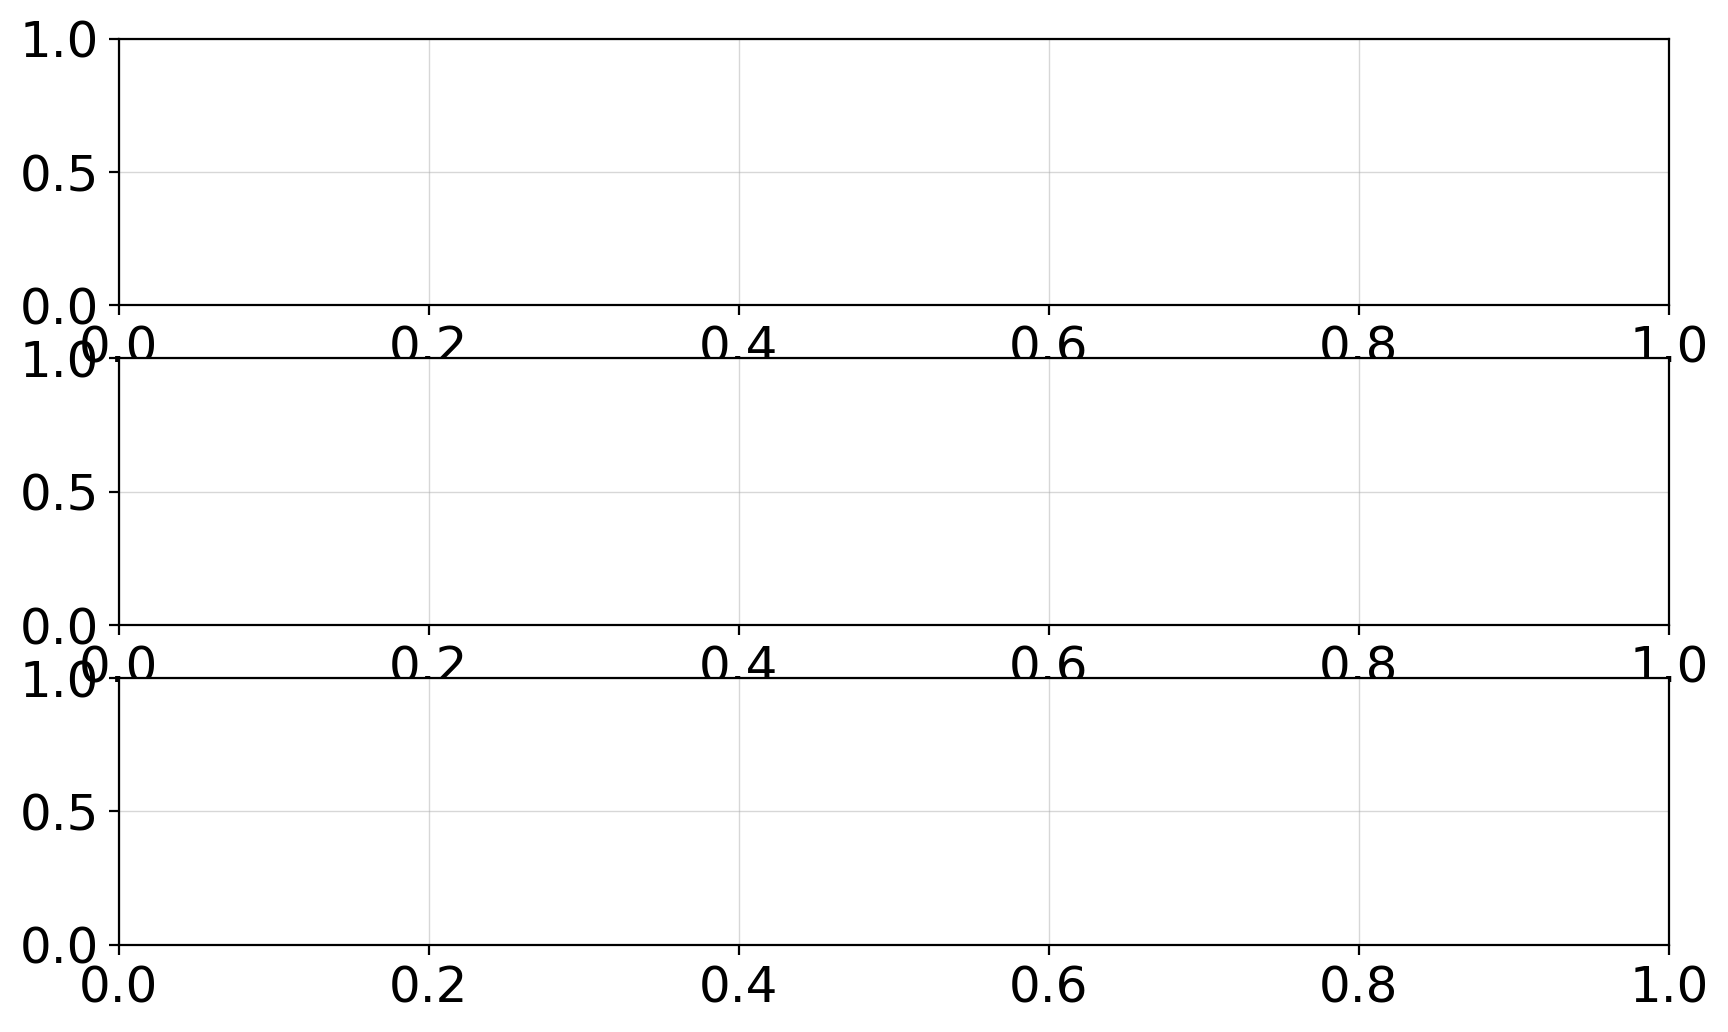

In [79]:

idx_1 = np.where(traj['V2']['stcb_base']['X [m]'] <= 10000)[0]
idx_2 = np.where(traj['Vmax']['stcb_adv']['X [m]'] <= 10000)[0]
idx_3 = np.where(traj['V2']['ptcb']['X [m]'] <= 10000)[0]
idx_4 = np.where(traj['Vmax']['ptcb']['X [m]'] <= 10000) [0]



# ax[1].plot(traj['V2']['stcb_base']['X [m]'], traj['V2']['stcb_base']['V [m/s]'], color='tab:blue')
# ax[1].plot(traj['Vmax']['stcb_adv']['X [m]'], traj['Vmax']['stcb_adv']['V [m/s]'], '-', color='tab:orange')
# ax[1].plot(traj['V2']['ptcb']['X [m]'], traj['V2']['ptcb']['V [m/s]'], '-', color='tab:green')
# ax[1].plot(traj['Vmax']['ptcb']['X [m]'], traj['Vmax']['ptcb']['V [m/s]'], '-', color='tab:red')
# ax[1].set_xlim([-100, 9000])
# ax[1].set_xticklabels([])
# ax[1].set_ylabel('V [m/s]')
# ax[1].set_ylim([-10, 135])

ax[1].plot(traj['V2']['stcb_base']['X [m]'][idx_1], traj['V2']['stcb_base']['TS [-]'][idx_1], '-', color='tab:blue')
# ax[1].plot(traj['Vmax']['stcb_adv']['X [m]'][idx_2], traj['Vmax']['stcb_adv']['TS [-]'][idx_2], '--', color='tab:orange')
ax[1].plot(traj['V2']['ptcb']['X [m]'][idx_3], traj['V2']['ptcb']['TS [-]'][idx_3], '-', color='tab:green')
ax[1].plot(traj['Vmax']['ptcb']['X [m]'][idx_4], traj['Vmax']['ptcb']['TS [-]'][idx_4], '--', color='tab:green')
# ax[1].plot(traj['Vmax']['phld']['X [m]'], traj['Vmax']['phld']['TS [-]'], '--', color='k')
ax[1].set_xlim([-100, 10100])
ax[1].set_ylim([0.35, 1.05])
ax[1].set_xticklabels([])
ax[1].set_yticks([0.4, 0.6, 0.8, 1.0])
ax[1].set_yticklabels([0.4, 0.6, 0.8, 1.0])
ax[1].set_ylabel('TS')

# ax[3].plot([-100, 8500], [np.max(data['V2']['stcb_sideline'][20, 0, :]), np.max(data['V2']['stcb_sideline'][20, 0, :])], '-', color='tab:blue', linewidth=1)
# ax[3].plot([-100, 8500], [np.max(data['Vmax']['stcb_sideline'][0, 3, :]), np.max(data['Vmax']['stcb_sideline'][0, 3, :])], '-', color='tab:orange', linewidth=1)
# ax[3].plot([-100, 8500], [np.max(data['V2']['ptcb_sideline']), np.max(data['V2']['ptcb_sideline'])], '-', color='tab:green', linewidth=1)
# ax[3].plot([-100, 8500], [np.max(data['Vmax']['ptcb_sideline']), np.max(data['Vmax']['ptcb_sideline'])], '-', color='tab:green', linewidth=1)

epnl_sideline_V2_high = np.array([ 90.84120548,  90.89278809,  90.64583324,  90.52563527,
        90.37730958,  90.25790275,  90.15215656,  90.06251864,
        89.96908419,  89.8713606 ,  89.8437594 ,  89.81777359,
        89.90554925,  89.97330339,  90.06688601,  90.19496146,
        90.36711723,  90.59512857,  90.80449042,  91.13896558,
        91.46205142,  91.81495912,  92.27593276,  92.73513648,
        93.30635153,  93.94329002,  94.61912067,  95.36900656,
        96.02201087,  96.71734393,  97.41221507,  98.03945583,
        98.4852246 ,  98.70662486,  99.16482677,  99.47746732,
        99.77984532,  99.76716175,  99.85566929,  99.73875057,
        99.7105636 ,  99.84565074, 100.02676723,  99.79546805,
        99.60044256,  99.47439561,  99.59515479,  99.69220597,
        99.62237311,  99.48304414,  99.40053634,  99.29927267,
        99.26536915,  99.16480784,  99.14636046,  99.06206146,
        98.93892336,  98.7832637 ,  98.68364735,  98.65796009,
        98.55299972,  98.45775695,  98.3270228 ,  98.22039737,
        98.11563364,  98.04530729,  97.9133432 ,  97.76769723,
        97.65678749,  97.52358872,  97.4616623 ,  97.35407313,
        97.26669337,  97.16749409,  97.07679505,  96.99133907,
        96.87619666,  96.71038366,  96.58610104,  96.4368723 ,
        96.26897934,  96.0473361 ,  95.8849496 ,  95.67831852,
        95.40633871,  95.15198089,  94.89432855,  94.61649771,
        94.28585852,  93.9547108 ,  93.63240116,  93.24620762,
        92.8301059 ,  92.42066614,  91.94848398,  91.44997321,
        91.05643205,  90.6355319 ,  90.24519306,  89.84443227,
        89.41327546,  89.03015561,  88.70767019,  88.31396341,
        87.96229941,  87.65978503,  87.37602238,  87.07631053,
        86.82849074,  86.57620654,  86.33419992,  86.12641161,
        85.90801417,  85.69723103,  85.4922474 ,  85.32302595,
        85.14371291,  84.99586368,  84.86615868,  84.72313187,
        84.59164772,  84.43630104,  84.31821056,  84.19371277,
        84.04797582,  83.91882299,  83.81783011,  83.71562799,
        83.63803972,  83.53753382,  83.45904915,  83.3840371 ,
        83.29901613,  83.23735837,  83.17887101,  83.10666123,
        83.05302042,  83.00615178,  82.96056365,  82.89166604,
        82.85177214,  82.80546032,  82.7409295 ,  82.67620002,
        82.62465773,  82.580554  ,  82.53776268,  82.51293964,
        82.46376156,  82.42643957,  82.38765013,  82.20703981,
        82.16096801,  82.15914666,  82.13224283,  82.10577188,
        82.08122146,  82.05463032,  82.03128243,  82.0023202 ,
        81.99828194,  81.97071086,  81.93157118,  81.9192945 ,
        81.89659179,  81.87679178,  81.84436443,  81.82579238,
        81.79698224,  81.77706261,  81.76644157,  81.72163873,
        81.70359178,  81.68802529,  81.66840503,  81.62632526,
        81.62155848,  81.5971039 ,  81.57129451,  81.5543636 ,
        81.52229873,  81.5037308 ,  81.47309312,  81.47398069,
        81.4225288 ,  81.4060604 ,  81.39608586,  81.35905143,
        81.35056903,  81.32760338,  81.32183186,  81.27997326,
        81.25854406,  81.24847295,  81.21619745,  81.18440211,
        81.18321621,  81.14016675,  81.13750048,  81.11049598,
        81.06913139])
epnl_sideline_Vmax_low= np.array([90.84169103, 90.58879188, 90.34078298, 90.09821714, 89.8772848 ,
       89.64907635, 89.43433071, 89.21877777, 88.98535238, 88.73003828,
       88.51089315, 88.32547652, 88.14967456, 88.00200444, 87.84898747,
       87.71453651, 87.59306722, 87.47166607, 87.35555811, 87.25909274,
       87.14782172, 87.04261643, 86.98207533, 86.88971222, 86.8708307 ,
       86.77635271, 86.68860392, 86.58207301, 86.47757061, 86.38494942,
       86.28087933, 86.23684709, 86.16299338, 86.11953304, 86.13820799,
       86.15128019, 86.35397269, 86.49545871, 86.89388471, 87.25756084,
       87.96652427, 88.46159624, 89.2405359 , 89.79842195, 90.83408295,
       91.28069774, 91.72464842, 91.9110342 , 91.76806616, 91.77569488,
       91.82337589, 91.6791671 , 91.41199509, 91.3722932 , 91.2808337 ,
       91.02157895, 90.68550159, 90.75832079, 90.86127873, 90.90780823,
       90.59058008, 90.44279211, 90.48139309, 90.54386014, 90.56134159,
       90.55441069, 90.55874538, 90.37792337, 90.28817926, 90.09882985,
       89.84634913, 89.66003905, 89.79166456, 89.7535775 , 89.6483032 ,
       89.45579055, 89.28184359, 89.42477275, 89.42821244, 89.23372799,
       89.20747077, 89.21183377, 89.20220138, 89.11966677, 89.0797039 ,
       88.9517459 , 88.82777549, 88.81052117, 88.72180839, 88.58226256,
       88.57725322, 88.44680185, 88.41329716, 88.36203491, 88.23066119,
       88.23477456, 88.16084943, 88.08190999, 88.06720353, 87.96387655,
       87.91178539, 87.83123681, 87.80959483, 87.76438232, 87.65958133,
       87.64737937, 87.58447171, 87.49819773, 87.46844441, 87.37726384,
       87.3447701 , 87.22606362, 87.22262264, 87.15765921, 87.05443051,
       87.04406906, 86.95623459, 86.93608473, 86.86731225, 86.81381369,
       86.76598816, 86.70078786, 86.64695984, 86.5697632 , 86.53153049,
       86.46264741, 86.43554884, 86.38188852, 86.33089261, 86.27860205,
       86.21850638, 86.19174835, 86.10629832, 86.07612966, 86.02439358,
       85.9547379 , 85.90475667, 85.8431021 , 85.80899987, 85.71950117,
       85.68912652, 85.64157789, 85.55633987, 85.51847272, 85.47397306,
       85.37634866, 85.3700001 , 85.29831918, 85.23970712, 85.18414496,
       85.1184573 , 85.06794801, 85.00323631, 84.96877872, 84.88271791,
       84.83865878, 84.76393088, 84.71153819, 84.66687081, 84.60038948,
       84.56376933, 84.48277568, 84.43895918, 84.38760333, 84.32204841,
       84.25950111, 84.18344318, 84.13721324, 84.09303994, 84.03546481,
       83.99880886, 83.93449024, 83.89501966, 83.83241086, 83.7939164 ,
       83.73248227, 83.67954571, 83.62295115, 83.59649098, 83.51627285,
       83.4900052 , 83.42048075, 83.38047449, 83.31635846, 83.28163349,
       83.21676465, 83.18591469, 83.1214869 , 83.0633113 , 83.02580968,
       82.96471779, 82.90489513, 82.88961033, 82.82578121, 82.77421575,
       82.72215478, 82.65977592, 82.62768784, 82.54979218, 82.51339485,
       82.47969658])

ax[2].plot(np.linspace(0, 10000, 201), epnl_sideline_V2_high, '-', color='tab:blue')
# ax[2].plot(np.linspace(0, 10000, 201), epnl_sideline_Vmax_low, '--', color='tab:orange')
ax[2].plot(np.linspace(0, 10000, 161), epnl_data['V2']['ptcb_sideline'], '-', color='tab:green')
ax[2].plot(np.linspace(0, 10000, 161), epnl_data['Vmax']['ptcb_sideline'], '--', color='tab:green')
# ax[2].plot(np.linspace(1500, 5500, 161), data['Vmax']['phld_sideline'], '--', color='k', label='PTCB (128.6 m/s (250 kts))')
ax[2].set_yticks([80, 90, 100])
ax[2].set_xlim([-100, 10100])
ax[2].set_ylim([79, 101])
ax[2].set_xlabel('X [m]')
ax[2].set_ylabel('$EPNL_{sideline}$ \n[EPNdB]')

# plt.subplots_adjust(hspace=0.3)

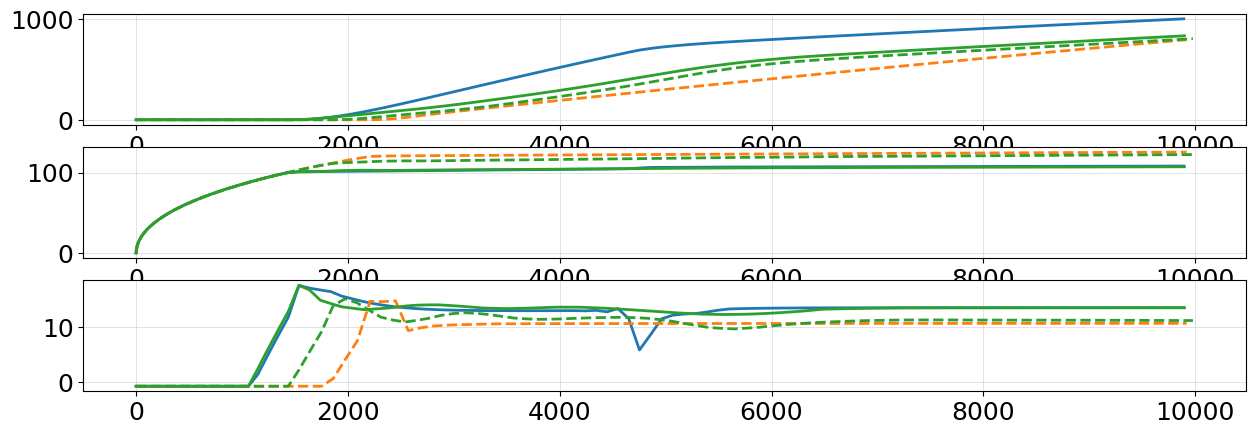

In [63]:
fig, ax = plt.subplots(3,1, figsize=(15,5))

ax[0].plot(traj['v2']['stcb_base']['X [m]'][idx_1], traj['v2']['stcb_base']['Z [m]'][idx_1], color='tab:blue', label='STCB ($z_{cb} \geq 260m$; V2 + 20 kts)')
ax[0].plot(traj['vmax']['stcb_adv']['X [m]'][idx_2], traj['vmax']['stcb_adv']['Z [m]'][idx_2], '--', color='tab:orange', label='STCB ($z_{cb} < 260m$; 250 kts)')
ax[0].plot(traj['v2']['ptcb']['X [m]'][idx_3], traj['v2']['ptcb']['Z [m]'][idx_3], '-', color='tab:green', label='PTCB (V2 + 20 kts)')
ax[0].plot(traj['vmax']['ptcb']['X [m]'][idx_4], traj['vmax']['ptcb']['Z [m]'][idx_4], '--', color='tab:green', label='PTCB (250 kts)')

# ax[0].set_xlim([0, 2000])
# ax[0].set_ylim([-10, 50])

ax[1].plot(traj['v2']['stcb_base']['X [m]'][idx_1], traj['v2']['stcb_base']['V [m/s]'][idx_1], '-', color='tab:blue')
ax[1].plot(traj['vmax']['stcb_adv']['X [m]'][idx_2], traj['vmax']['stcb_adv']['V [m/s]'][idx_2], '--', color='tab:orange')
ax[1].plot(traj['v2']['ptcb']['X [m]'][idx_3], traj['v2']['ptcb']['V [m/s]'][idx_3], '-', color='tab:green')
ax[1].plot(traj['vmax']['ptcb']['X [m]'][idx_4], traj['vmax']['ptcb']['V [m/s]'][idx_4], '--', color='tab:green')

ax[2].plot(traj['v2']['stcb_base']['X [m]'][idx_1], traj['v2']['stcb_base']['alpha [deg]'][idx_1], '-', color='tab:blue')
ax[2].plot(traj['vmax']['stcb_adv']['X [m]'][idx_2], traj['vmax']['stcb_adv']['alpha [deg]'][idx_2], '--', color='tab:orange')
ax[2].plot(traj['v2']['ptcb']['X [m]'][idx_3], traj['v2']['ptcb']['alpha [deg]'][idx_3], '-', color='tab:green')
ax[2].plot(traj['vmax']['ptcb']['X [m]'][idx_4], traj['vmax']['ptcb']['alpha [deg]'][idx_4], '--', color='tab:green')
# ax[1].set_xlim([0, 2000])

In [151]:
# Load verification trajectory 
nasa_std = pd.read_csv('../cases/nasa_stca_standard/trajectory/Trajectory_to.csv')

pyna_settings = pyna.load_settings(case_name='stca')
pyna_settings.engine_file_name = "engine_deck_stca.csv"
pyna_settings.TS_to = 1.
pyna_settings.TS_vnrs = 0.56
pyna_settings.TS_cutback = 0.56
pyna_settings.z_cutback = 25.
pyna_settings.save_results = False
pyna_settings.levels_int_metric = 'ipnlt'
pyna_settings.output_directory_name = 'PTCB/V2_final'
pyna_settings.output_file_name = 'stca_ptcb_v2.sql'

pyna_settings.noise_constraint_lateral = 1.
pyna_settings.PTCB = True
pyna_settings.PKROT = True
pyna_settings.PHLD = False
pyna_settings.shielding = False

pyna_settings.fan_inlet = True
pyna_settings.fan_discharge = True
pyna_settings.core = True
pyna_settings.airframe = False
pyna_settings.jet_shock = False
pyna_settings.jet_mixing = True
pyna_settings.all_sources = False

# Simplifications
pyna_settings.N_b = 1
pyna_settings.max_iter = 150
pyna_settings.n_order = 3

py = pyna(pyna_settings)

In [168]:
# Compute full thrust
F_n_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['F_n'])


F_n_full_v2   = F_n_interp(( np.maximum(np.ones(np.size(traj['v2']['ptcb']['Z [m]'].values)), traj['v2']['ptcb']['Z [m]'].values), traj['v2']['ptcb']['M_0 [-]'].values, np.ones(np.size(traj['v2']['ptcb']['Z [m]'].values))))
F_n_full_vmax = F_n_interp(( np.maximum(np.ones(np.size(traj['vmax']['ptcb']['Z [m]'].values)), traj['vmax']['ptcb']['Z [m]'].values), traj['vmax']['ptcb']['M_0 [-]'].values, np.ones(np.size(traj['vmax']['ptcb']['Z [m]'].values))))



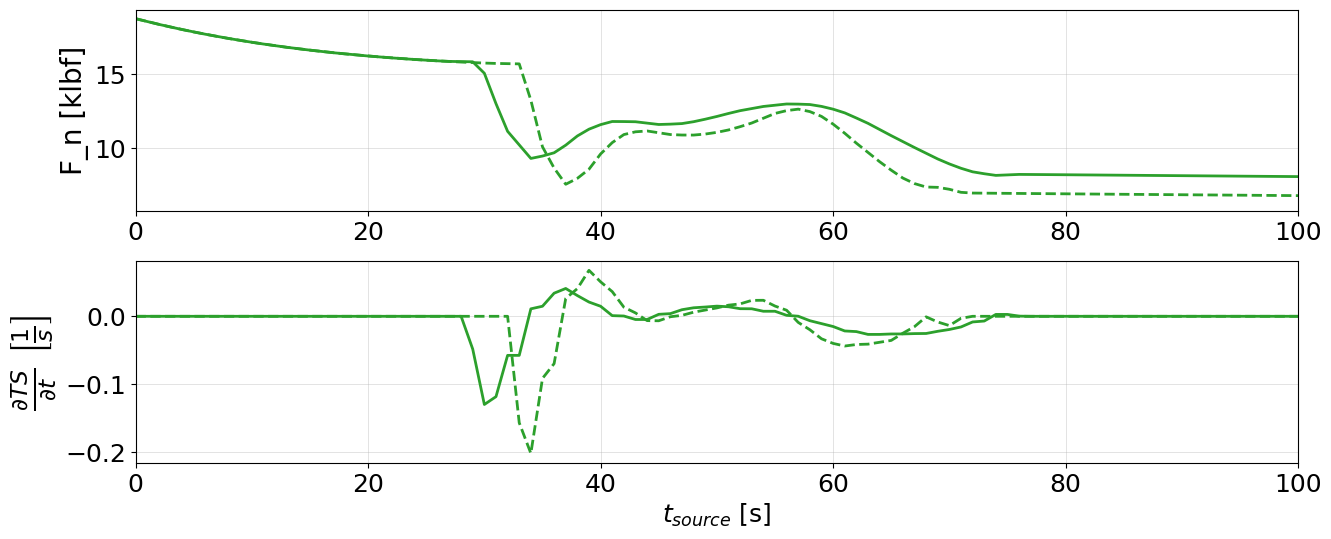

In [207]:
fig, ax = plt.subplots(2,1, figsize=(15,6))
plt.style.use('../utils/plot.mplstyle')



ax[0].plot(traj['v2']['ptcb']['t_source [s]'], traj['v2']['ptcb']['F_n [N]']/1000*0.224, '-', color='tab:green')
ax[0].plot(traj['vmax']['ptcb']['t_source [s]'], traj['vmax']['ptcb']['F_n [N]']/1000*0.224, '--', color='tab:green')
ax[0].set_xlim([0, 100])
# ax[0].set_ylim([0.4, 1.05])
ax[0].set_ylabel('F_n [klbf]', fontsize=20)

ax[1].plot(traj['v2']['ptcb']['t_source [s]'][:-1], np.diff(traj['v2']['ptcb']['TS [-]'])/np.diff(traj['v2']['ptcb']['t_source [s]']), '-', color='tab:green')
ax[1].plot(traj['vmax']['ptcb']['t_source [s]'][:-1], np.diff(traj['vmax']['ptcb']['TS [-]'])/np.diff(traj['vmax']['ptcb']['t_source [s]']), '--', color='tab:green')
ax[1].set_xlim([0, 100])

ax[1].set_xlabel('$t_{source}$ [s]')
ax[1].set_ylabel(r'$\frac{\partial TS}{\partial t}\ \left[\frac{1}{s}\right]$', fontsize=24)

plt.subplots_adjust(hspace=0.25)